# 08 - Unbalanced Datasets

by [Alejandro Correa Bahnsen](albahnsen.com/)

version 0.2, May 2016

## Part of the class [Machine Learning for Risk Management](https://github.com/albahnsen/ML_RiskManagement)



This notebook is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). Special thanks goes to [Kevin Markham](https://github.com/justmarkham)

## Background

Unbalanced classification problems cause problems to many learning algorithms. These problems are characterized by the uneven proportion of cases that are available for each class of the problem.

Most classification algorithms will only perform optimally when the number of samples of each class is roughly the same. Highly skewed datasets, where the minority heavily outnumbered by one or more classes, haven proven to be a challenge while at the same time becoming more and more common.

One way of addresing this issue is by resampling the dataset as to offset this imbalance with the hope of arriving and a more robust and fair decision boundary than you would otherwise.

Resampling techniques are divided in two categories: 
* Under-sampling the majority class(es)
* Over-sampling the minority class

In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
plt.style.use('ggplot')

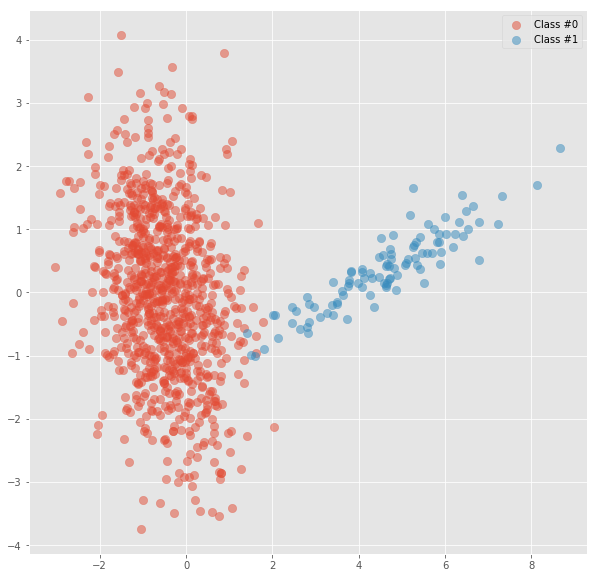

In [2]:

# Generate some data
X, y = make_classification(n_classes=2, class_sep=2, weights=[0.9, 0.1],
                           n_informative=3, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1,
                           n_samples=1000, random_state=10)

# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components = 2)

# Fit and transform x to visualise inside a 2D feature space
x_vis = pca.fit_transform(X)

# Plot the original data

def plot_two_classes(X, y, subplot=False, size=(10, 10)):
    # Plot the two classes
    if subplot == False:
        fig, subplot = plt.subplots(nrows=1, ncols=1, figsize=size)
        
    subplot.scatter(X[y==0, 0], X[y==0, 1], label="Class #0", 
                    alpha=0.5, s=70)
    subplot.scatter(X[y==1, 0], X[y==1, 1], label="Class #1", 
                    alpha=0.5, s=70)
    subplot.legend()
    return subplot

plot_two_classes(x_vis, y)

In [3]:
y.mean()

0.1

# Part 1: Under-sampling

## Random - Under-sampling
Randomly select a percentage of the negative class such that the resulting dataset is balanced

In [4]:
n_samples = y.shape[0]
print(n_samples)

1000


In [5]:
n_samples_0 = (y == 0).sum()
n_samples_0

900

In [6]:
n_samples_1 = (y == 1).sum()
n_samples_1

100

In [7]:
n_samples_1 / n_samples

0.1

How many negatives cases should I select if I want a new dataset with 50% of positives?

0.5 = n_samples_1 / (n_samples_1 + n_samples_0_new)

(n_samples_1 + n_samples_0_new) = n_samples_1 / 0.5

In [8]:
n_samples_0_new =  n_samples_1 / 0.5 - n_samples_1
n_samples_0_new

100.0

In [9]:
n_samples_0_new_per = n_samples_0_new / n_samples_0
n_samples_0_new_per

0.1111111111111111

Create a filter to select `n_samples_0_new_per` from the negative class

In [10]:
# Select all negatives
filter_ = y == 0

# Random sample
np.random.seed(42)
rand_1 = np.random.binomial(n=1, p=n_samples_0_new_per, size=n_samples)

# Combine
filter_ = filter_ & rand_1

In [11]:
filter_.sum()

108

Also select all the positives

In [12]:
filter_ = filter_ | (y == 1)

In [13]:
filter_ = filter_.astype(bool)

plot

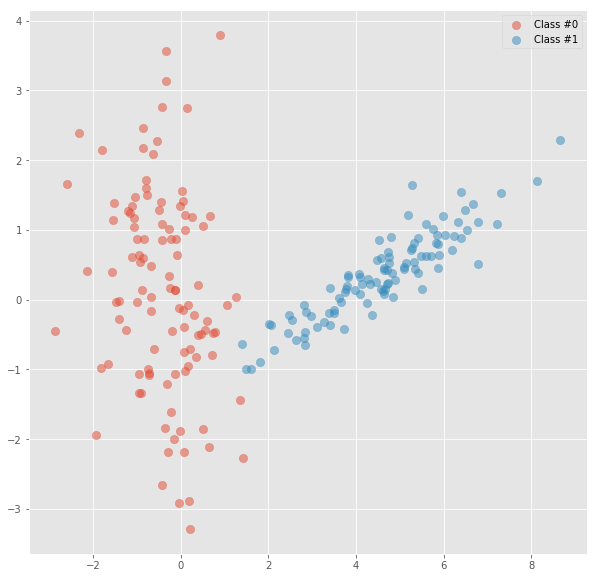

In [14]:
plot_two_classes(x_vis[filter_], y[filter_])

Convert into a function

In [15]:
def UnderSampling(X, y, target_percentage=0.5, seed=None):
    # Assuming minority class is the positive
    n_samples = y.shape[0]
    n_samples_0 = (y == 0).sum()
    n_samples_1 = (y == 1).sum()

    n_samples_0_new =  n_samples_1 / target_percentage - n_samples_1
    n_samples_0_new_per = n_samples_0_new / n_samples_0

    filter_ = y == 0

    np.random.seed(seed)
    rand_1 = np.random.binomial(n=1, p=n_samples_0_new_per, size=n_samples)
    
    filter_ = filter_ & rand_1
    filter_ = filter_ | (y == 1)
    filter_ = filter_.astype(bool)
    
    return X[filter_], y[filter_]

Target percentage 0.1
y.shape =  1000 y.mean() =  0.1


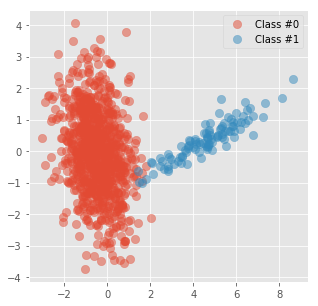

Target percentage 0.2
y.shape =  510 y.mean() =  0.19607843137254902


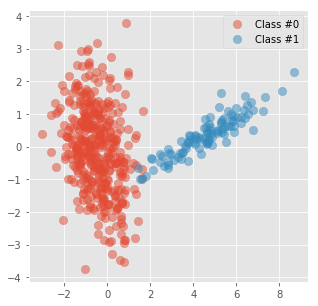

Target percentage 0.3
y.shape =  343 y.mean() =  0.2915451895043732


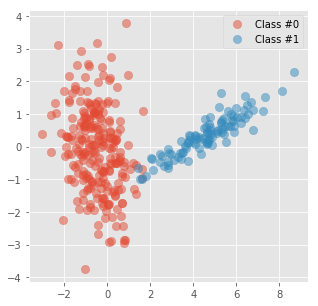

Target percentage 0.4
y.shape =  249 y.mean() =  0.40160642570281124


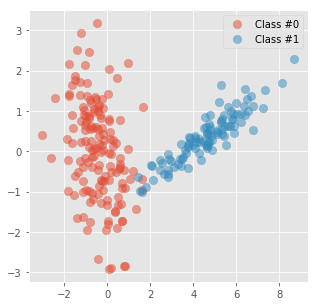

Target percentage 0.5
y.shape =  199 y.mean() =  0.5025125628140703


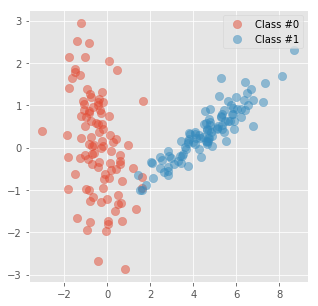

In [16]:
for target_percentage in [0.1, 0.2, 0.3, 0.4, 0.5]:
    X_u, y_u = UnderSampling(x_vis, y, target_percentage, 1)
    print('Target percentage', target_percentage)
    print('y.shape = ',y_u.shape[0], 'y.mean() = ', y_u.mean())
    plot_two_classes(X_u, y_u, size=(5, 5))
    plt.show()    

### Comparing Under-Sampling with other models

**Advantages of Under-Sampling:**

- Fast to estimate
- Easy to understand

**Disadvantages of Under-Sampling:**

- Information of the negative class is lost
- Variance due to randomnes 
- Need to define the target percentage

## TomekLinks

Identify and remove majority samples that form a Tomek link with minority samples.



Find the nearest neighbour of every point

In [17]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=2)
nn.fit(x_vis)
nns = nn.kneighbors(x_vis, return_distance=False)[:, 1]

In [18]:
nns[0:10]

array([209, 633, 161, 610, 854, 268, 827, 205, 211, 940])

Find if tomek. Use the target vector and the first neighbour of every sample
point and looks for Tomek pairs. Returning a boolean vector with True
for majority Tomek links.

In [19]:
# Initialize the boolean result as false, and also a counter
links = np.zeros(len(y), dtype=bool)

# Loop through each sample of the majority class then we
# look at its first neighbour. If its closest neighbour also has the
# current sample as its closest neighbour, the two form a Tomek link.
for ind, ele in enumerate(y):

    if ele == 1 | links[ind] == True:  # Keep all from the minority class
        continue

    if y[nns[ind]] == 1:

        # If they form a tomek link, put a True marker on this
        # sample, and increase counter by one.
        if nns[nns[ind]] == ind:
            links[ind] = True


In [20]:
links.sum()

2

In [21]:
filter_ = np.logical_not(links)

y.shape =  998 y.mean() =  0.10020040080160321


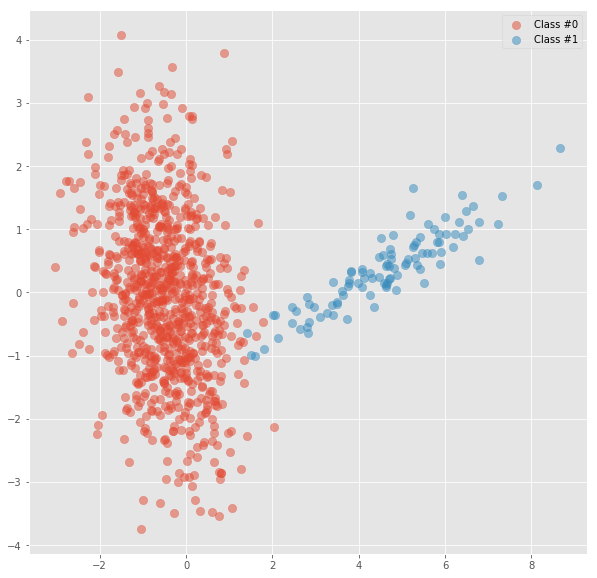

In [22]:
print('y.shape = ',y[filter_].shape[0], 'y.mean() = ', y[filter_].mean())
plot_two_classes(x_vis[filter_], y[filter_])

### Comparing TomekLinks with other models

**Advantages of TomekLinks:**

- Creates a linearly-separable space

**Disadvantages of TomekLinks:**

- Still a highly imbalance dataset

## Condensed Nearest Neighbour

The goal is to eliminate examples from
the majority class that are much further
away from the border

In [23]:
# Import the K-NN classifier
from sklearn.neighbors import KNeighborsClassifier

In [24]:
# Number of samples to extract in order to build the set S.
n_seeds_S = 51

# Size of the neighbourhood to consider to compute the
# average distance to the minority point samples.
size_ngh = 100

# Randomly get one sample from the majority class
np.random.seed(42)
maj_sample = np.random.choice(x_vis[y == 0].shape[0], n_seeds_S)
maj_sample = x_vis[y == 0][maj_sample]

In [25]:
# Create the set C
# Select all positive and the randomly selected negatives
C_x = np.append(x_vis[y == 1], maj_sample, axis=0)
C_y = np.append(y[y == 1], [0] * n_seeds_S)

In [26]:
# Create the set S
S_x = x_vis[y == 0]
S_y = y[y == 0]

In [27]:
knn = KNeighborsClassifier(n_neighbors=size_ngh)

# Fit C into the knn
knn.fit(C_x, C_y)

# Classify on S
pred_S_y = knn.predict(S_x)

In [28]:
# Find the misclassified S_y
idx_tmp = np.nonzero(y == 0)[0][np.nonzero(pred_S_y != S_y)]

In [29]:
filter_ = np.nonzero(y == 1)[0]
filter_ = np.concatenate((filter_, idx_tmp), axis=0)

y.shape =  174 y.mean() =  0.5747126436781609


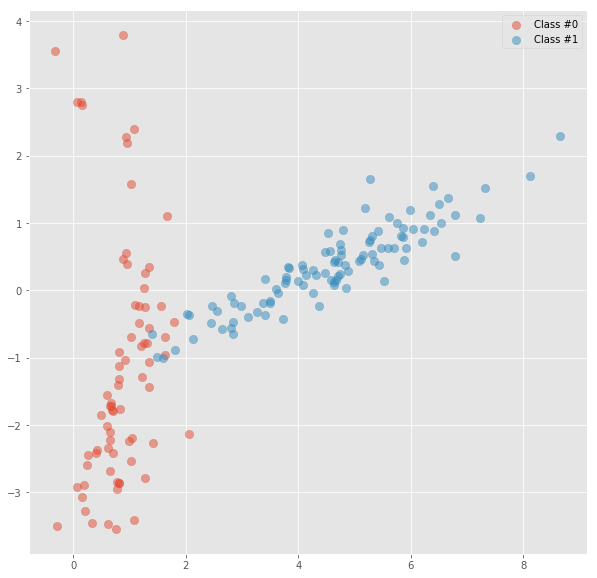

In [30]:
print('y.shape = ',y[filter_].shape[0], 'y.mean() = ', y[filter_].mean())
plot_two_classes(x_vis[filter_], y[filter_])

In [31]:
# Import the K-NN classifier
from sklearn.neighbors import KNeighborsClassifier
def CondensedNearestNeighbor(X, y, n_seeds_S=1, size_ngh=1, seed=None):
    # Randomly get one sample from the majority class
    np.random.seed(seed)
    maj_sample = np.random.choice(X[y == 0].shape[0], n_seeds_S)
    maj_sample = X[y == 0][maj_sample]
    # Create the set C
    # Select all positive and the randomly selected negatives
    C_x = np.append(X[y == 1], maj_sample, axis=0)
    C_y = np.append(y[y == 1], [0] * n_seeds_S)
    # Create the set S
    S_x = X[y == 0]
    S_y = y[y == 0]
    knn = KNeighborsClassifier(n_neighbors=size_ngh)

    # Fit C into the knn
    knn.fit(C_x, C_y)

    # Classify on S
    pred_S_y = knn.predict(S_x)
    # Find the misclassified S_y
    idx_tmp = np.nonzero(y == 0)[0][np.nonzero(pred_S_y != S_y)]

    filter_ = np.nonzero(y == 1)[0]
    filter_ = np.concatenate((filter_, idx_tmp), axis=0)

    return X[filter_], y[filter_]

n_seeds_S  1 size_ngh  1
y.shape =  389 y.mean() =  0.2570694087403599


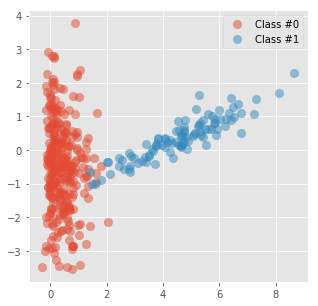

n_seeds_S  100 size_ngh  100
y.shape =  100 y.mean() =  1.0


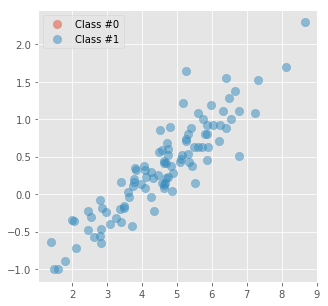

n_seeds_S  50 size_ngh  50
y.shape =  111 y.mean() =  0.9009009009009009


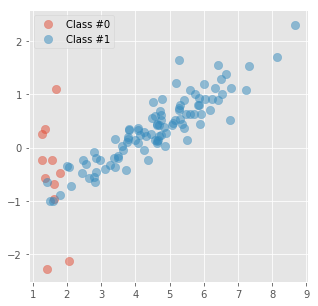

n_seeds_S  100 size_ngh  50
y.shape =  102 y.mean() =  0.9803921568627451


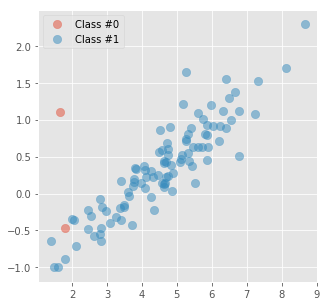

n_seeds_S  50 size_ngh  100
y.shape =  252 y.mean() =  0.3968253968253968


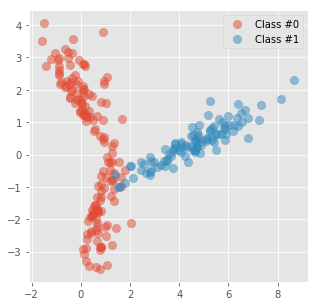

In [33]:
for n_seeds_S, size_ngh in [(1, 1), (100, 100), (50, 50), (100, 50), (50, 100)]:
    X_u, y_u = CondensedNearestNeighbor(x_vis, y, n_seeds_S, size_ngh, 1)
    print('n_seeds_S ', n_seeds_S, 'size_ngh ', size_ngh)
    print('y.shape = ',y_u.shape[0], 'y.mean() = ', y_u.mean())
    plot_two_classes(X_u, y_u, size=(5, 5))
    plt.show()    

### Comparing CondensedNearestNeighbor with other models

**Advantages of CondensedNearestNeighbor:**

- Create Condensed space

**Disadvantages of CondensedNearestNeighbor:**

- Variance due to randomnes 
- Need to define the two parameters

## Other Under-sampling methods

* Under-sampling with Cluster Centroids
* NearMiss-(1 & 2 & 3)
* One-Sided Selection
* Neighboorhood Cleaning Rule

# Part 2: Over-Sampling

## Random over-sampling

Replicate the minority class examples to increase
their relevance

In [34]:
import random
def OverSampling(X, y, target_percentage=0.5, seed=None):
    # Assuming minority class is the positive
    n_samples = y.shape[0]
    n_samples_0 = (y == 0).sum()
    n_samples_1 = (y == 1).sum()

    n_samples_1_new =  -target_percentage * n_samples_0 / (target_percentage- 1)

    np.random.seed(seed)
    filter_ = np.random.choice(X[y == 1].shape[0], int(n_samples_1_new))
    # filter_ is within the positives, change to be of all
    filter_ = np.nonzero(y == 1)[0][filter_]
    
    filter_ = np.concatenate((filter_, np.nonzero(y == 0)[0]), axis=0)
    
    return X[filter_], y[filter_]

Target percentage 0.1
y.shape =  1000 y.mean() =  0.1


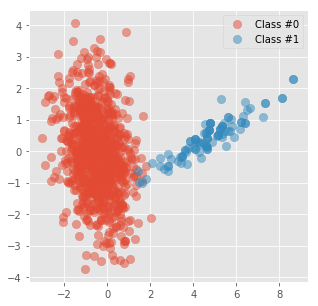

Target percentage 0.2
y.shape =  1125 y.mean() =  0.2


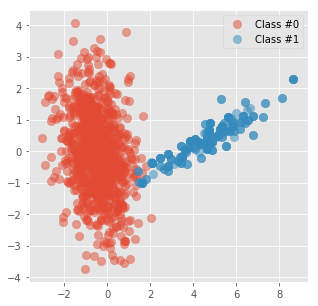

Target percentage 0.3
y.shape =  1285 y.mean() =  0.29961089494163423


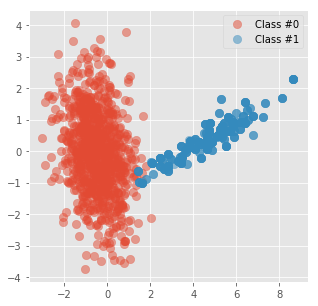

Target percentage 0.4
y.shape =  1500 y.mean() =  0.4


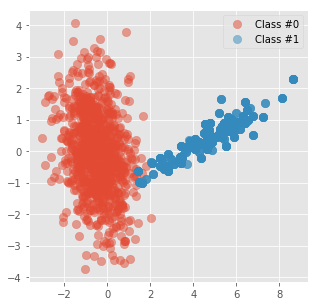

Target percentage 0.5
y.shape =  1800 y.mean() =  0.5


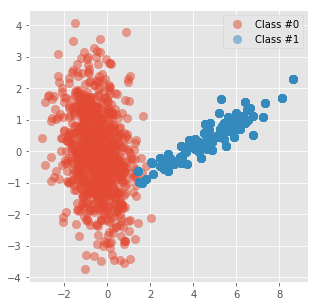

In [35]:
for target_percentage in [0.1, 0.2, 0.3, 0.4, 0.5]:
    X_u, y_u = OverSampling(x_vis, y, target_percentage, 1)
    print('Target percentage', target_percentage)
    print('y.shape = ',y_u.shape[0], 'y.mean() = ', y_u.mean())
    plot_two_classes(X_u, y_u, size=(5, 5))
    plt.show()    

### Comparing Over-Sampling with other models

**Advantages of Over-Sampling :**

- Fast to estimate
- Easy to understant
- No information of the majority class is lost

**Disadvantages of Over-Sampling :**

- No new information is added
- Hurts the generalization capacity
- Variance due to randomnes 
- Need to define the target percentage

## SMOTE

SMOTE (Chawla et. al. 2002) is a well-known algorithm to fight this problem. The general idea of this method is to artificially generate new examples of the minority class using the nearest neighbors of these cases. Furthermore, the majority class examples are also under-sampled, leading to a more balanced dataset.

In [36]:
# Number of nearest neighbours to used to construct synthetic samples.
k = 5

from sklearn.neighbors import NearestNeighbors
nearest_neighbour_ = NearestNeighbors(n_neighbors=k + 1)

In [37]:
# Look for k-th nearest neighbours, excluding, of course, the
# point itself.#
nearest_neighbour_.fit(x_vis[y==1])

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=6, p=2, radius=1.0)

In [38]:
# Matrix with k-th nearest neighbours indexes for each minority
# element.#
nns = nearest_neighbour_.kneighbors(x_vis[y==1], 
                                    return_distance=False)[:, 1:]

Example of the nns of two cases

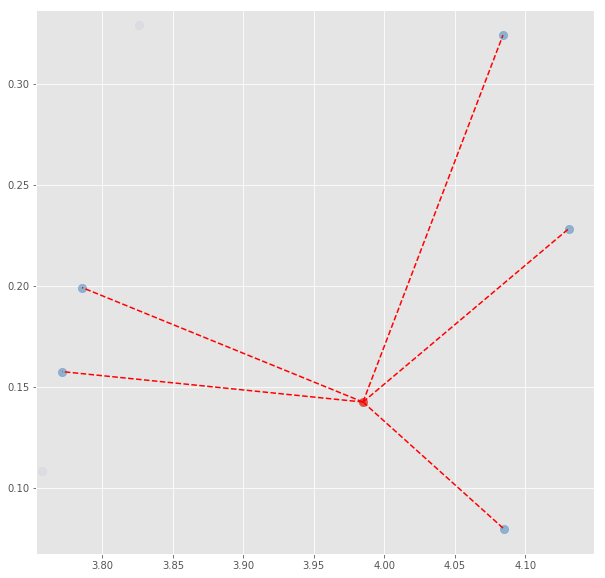

In [39]:
def base_smote_plot(sel, nns):
    fig, subplot = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    
    for i in range(len(sel)):
        # plot the select sample
        subplot.scatter(x_vis[y==1, 0][sel[i]], x_vis[y==1, 1][sel[i]],
                alpha=1., s=70)
        # plot the neighbors
        subplot.scatter(x_vis[y==1, 0][nns[sel[i]]], 
                        x_vis[y==1, 1][nns[sel[i]]],
                        alpha=0.5, s=70) 
        
        # plot the lines
        for nn in nns[sel[i]]:
            plt.plot([x_vis[y==1, 0][sel[i]], x_vis[y==1, 0][nn]],  
                     [x_vis[y==1, 1][sel[i]], x_vis[y==1, 1][nn]],
                     'r--') 
    
    xlim = subplot.get_xlim()
    ylim = subplot.get_ylim()
    subplot.scatter(x_vis[y==1, 0], x_vis[y==1, 1], alpha=0.1, s=70)
    subplot.set_xlim(xlim)
    subplot.set_ylim(ylim)
    return subplot
base_smote_plot([12],nns)

In [40]:
# Create syntetic sample for 12

# Select one random neighbor
np.random.seed(3)
nn_ = np.random.choice(nns[12])

x_vis[y==1][nn_]

array([4.08408373, 0.32401715])

In [41]:
# Take a step of random size (0,1) in the direction of the
# n nearest neighbours
np.random.seed(5)
step = np.random.uniform()

# Construct synthetic sample
new = x_vis[y==1][12] - step * (x_vis[y==1][12] - x_vis[y==1][nn_])
new

array([4.00686763, 0.18267361])

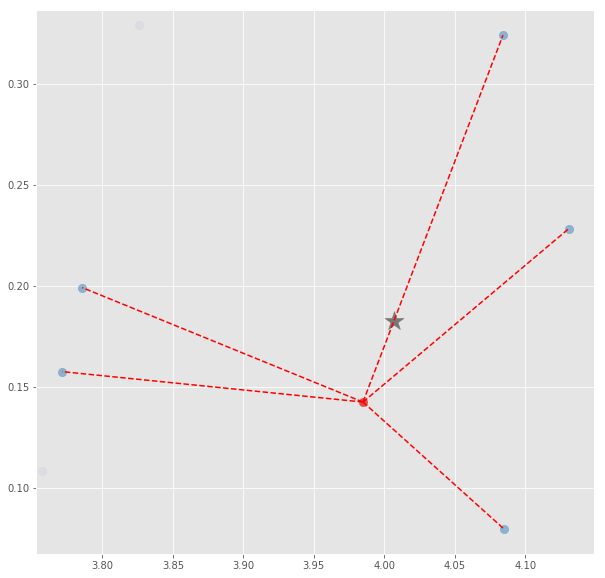

In [42]:
plot_ = base_smote_plot([12],nns)
plot_.scatter(new[0], new[1], alpha=1., s=400, marker="*")

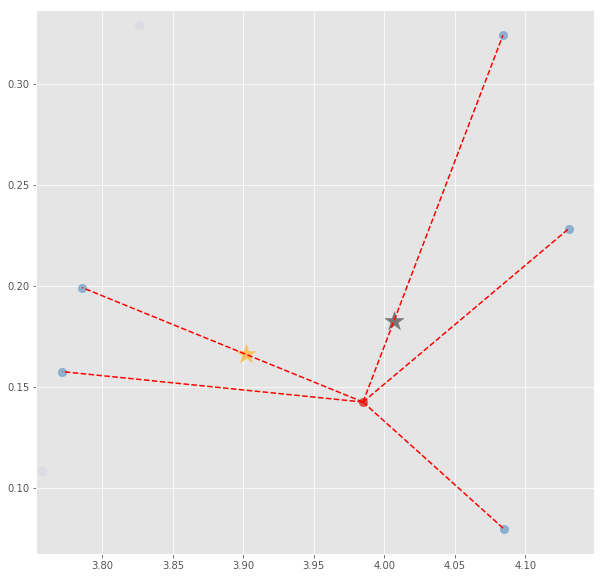

In [43]:
# Select one random neighbor
np.random.seed(5)
nn_2 = np.random.choice(nns[12])
np.random.seed(1)
step = np.random.uniform()
# Construct synthetic sample
new2 = x_vis[y==1][12] - step * (x_vis[y==1][12] - x_vis[y==1][nn_2])

plot_ = base_smote_plot([12],nns)
plot_.scatter(new[0], new[1], alpha=1., s=400, marker="*")
plot_.scatter(new2[0], new2[1], alpha=1., s=400, marker="*")

Apply to all cases

Estimate number of synthetic cases to create

In [44]:
target_percentage = 0.5
n_samples_1_new =  -target_percentage * n_samples_0 / (target_percentage- 1) - n_samples_1
n_samples_1_new = int(n_samples_1_new)
n_samples_1_new

800

In [45]:
# A matrix to store the synthetic samples
new = np.zeros((n_samples_1_new, x_vis.shape[1]))

In [46]:
# Select examples to use as base
np.random.seed(34)
sel_ = np.random.choice(y[y==1].shape[0], n_samples_1_new)

In [47]:
# Define random seeds (2 per example)
np.random.seed(64)
nn__ = np.random.choice(k, n_samples_1_new)
np.random.seed(65)
steps = np.random.uniform(size=n_samples_1_new)

In [48]:
# For each selected examples create one synthetic case
for i, sel in enumerate(sel_):
    # Select neighbor
    nn_ = nn__[i]
    step = steps[i]
    new[i, :] = x_vis[y==1][sel] - step * (x_vis[y==1][sel] - x_vis[y==1][nn_])

In [49]:
new

array([[4.99241781, 0.36993599],
       [4.9080866 , 0.41700365],
       [4.64491638, 0.34196693],
       ...,
       [5.59230647, 0.58805702],
       [5.47335375, 0.49006334],
       [5.08845915, 0.50425325]])

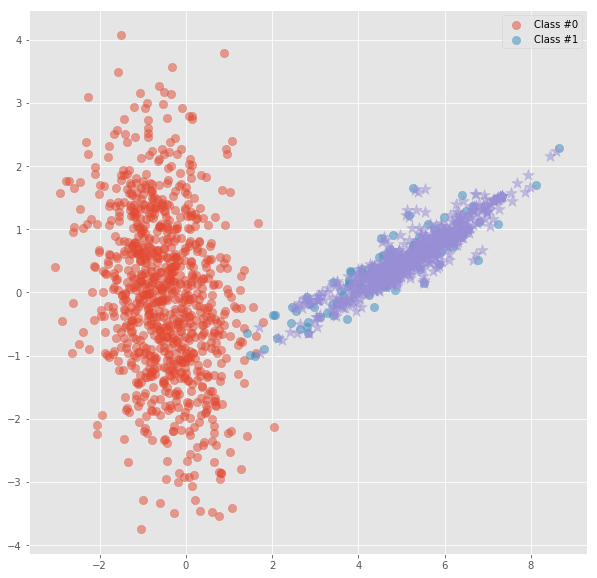

In [50]:
plot_ = plot_two_classes(x_vis, y, size=(10, 10))
plot_.scatter(new[:, 0], new[:, 1], alpha=0.5, s=150, marker='*')

Create function

In [51]:
def SMOTE(X, y, target_percentage=0.5, k=5, seed=None):
    
    # New samples
    n_samples_1_new =  int(-target_percentage * n_samples_0 / (target_percentage- 1) - n_samples_1)
    
    # A matrix to store the synthetic samples
    new = np.zeros((n_samples_1_new, x_vis.shape[1]))
    
    # Create seeds
    np.random.seed(seed)
    seeds = np.random.randint(1, 1000000, 3)
    
    # Select examples to use as base
    np.random.seed(seeds[0])
    sel_ = np.random.choice(y[y==1].shape[0], n_samples_1_new)
    
    # Define random seeds (2 per example)
    np.random.seed(seeds[1])
    nn__ = np.random.choice(k, n_samples_1_new)
    np.random.seed(seeds[2])
    steps = np.random.uniform(size=n_samples_1_new)  

    # For each selected examples create one synthetic case
    for i, sel in enumerate(sel_):
        # Select neighbor
        nn_ = nn__[i]
        step = steps[i]
        # Create new sample
        new[i, :] = X[y==1][sel] - step * (X[y==1][sel] - X[y==1][nn_])
    
    X = np.vstack((X, new))
    y = np.append(y, np.ones(n_samples_1_new))
    
    return X, y

Target percentage 0.25 k  5
y.shape =  1200 y.mean() =  0.25


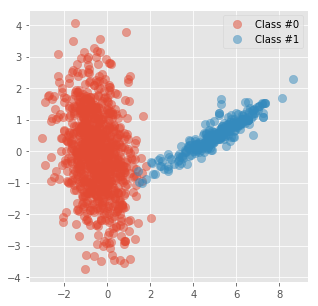

Target percentage 0.25 k  15
y.shape =  1200 y.mean() =  0.25


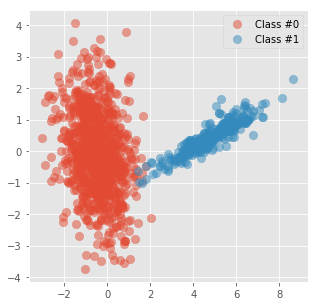

Target percentage 0.5 k  5
y.shape =  1800 y.mean() =  0.5


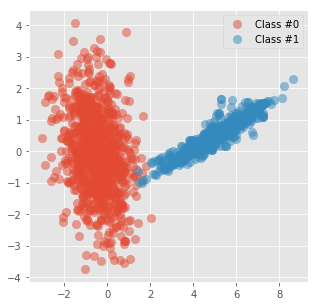

Target percentage 0.5 k  15
y.shape =  1800 y.mean() =  0.5


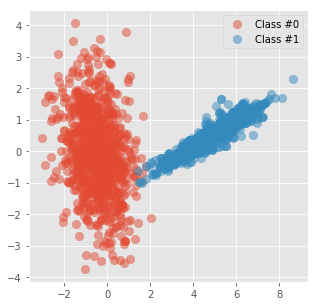

In [52]:
for target_percentage in [0.25, 0.5]:
    for k in [5, 15]:
        X_u, y_u = SMOTE(x_vis, y, target_percentage, k, seed=3)
        print('Target percentage', target_percentage, 'k ', k)
        print('y.shape = ',y_u.shape[0], 'y.mean() = ', y_u.mean())
        plot_two_classes(X_u, y_u, size=(5, 5))
        plt.show()    


### Comparing SMOTE with other models

**Advantages of SMOTE :**

- Allow generalization
- Add new information
- No information of the majority class is lost

**Disadvantages of SMOTE :**

- **Variance due to randomnes** 
- Need to define the target percentage, and k
- No synthetic example is created outside the convex-hull

## Other Over-sampling techniques

* bSMOTE(1&2) - Borderline SMOTE of types 1 and 2
* SVM_SMOTE - Support Vectors SMOTE